In [1]:
import numpy as np

def gini(x, sample_weight=None):
    """
    计算基尼系数 Gini(D)
    """
    x_num = len(x)
    if sample_weight is None:
        sample_weight = np.asarray([1.0] * x_num)
    x_counter = {}
    weight_counter = {}
    #统计各个x出现的次数和其对应的sample_weight列表
    for index in range(0, x_num):
        x_value = x[index]
        if x_counter.get(x_value) is None:
            x_counter[x_value] = 0
            weight_counter[x_value] = 0
        x_counter[x_value] +=1
        weight_counter[x_value].append(sample_weight[index])
    
    gini_value = 1.0
    for key,value in x_counter.items():
        p_i = 1.0 * value * np.mean(weight_counter.get(key)) / x_num
        gini_value -= p_i * p_i
    return gini_value

def cond_gini(x, y, sample_weight=None):
    """
    计算条件gini系数
    """
    x = np.asarray(x)
    y = np.asarray(y)
    x_num = len(x)
    if sample_weight is None:
        sample_weight = np.asarray([1.0] * x_num)
    gini_value = .0
    for x_value in set(x):
        #取x的值对应的类别
        x_index = np.where(x == x_value)
        new_x = x[x_index]
        new_y = y[x_index]
        new_sample_weight = sample_weight[x_index]
        p_i = 1.0*len(new_x) / x_num
        gini_value += p_i* gini(new_x, new_sample_weight)
    return gini_value

def gini_gain(x, y, sample_weight=None):
    """
    基尼值增益
    """
    x_num = len(x)
    if sample_weight is None:
        sample_weight = np.asarray([1.0] * x_num)
    return gini(y, sample_weight) - cond_gini(x, y, sample_weight)


In [2]:
import sys
sys.path.append("F:/MachineLearning/MachineLearn/ML_Notes-master/ML_Notes-master/")
from ml_models import utils
from ml_models.wrapper_models import DataBinWrapper

class CARTClassifier(object):
    class Node(object):
        """
        树节点，用于存储节点信息以及关联子节点
        """
        def __init__(self, feature_index: int = None, feature_value = None, target_distribute: dict = None,
                    weight_distribute: dict = None, left_child_node=None, right_child_node=None, num_sample: int=None):
            """
            :feature_index:特征id
            :feature_value: value of feature
            :target_distribute : 目标分布
            :weight_distribute :权重分布
            :param left_child_node: 左孩子结点
            :param right_child_node: 右孩子结点
            :param num_sample:样本量
            """
            self.feature_index = feature_index
            self.feature_value = feature_value
            self.target_distribute = target_distribute
            self.weight_distribute = weight_distribute
            self.left_child_node = left_child_node
            self.right_child_node = right_child_node
            self.num_sample = num_sample
            
    def __init__(self,criterion = 'gini', max_depth = None, min_samples_split=2, min_samples_leaf=1, min_impurity_decrease=0, max_bins=10):
        self.criterion = criterion
        if criterion == 'gini':
            self.criterion_func = utils.gini_gain
        else:
            self.criterion_func = utils.info_gain_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        
        self.root_node :self.Node = None
        self.dbw = DataBinWrapper(max_bins=max_bins)
    
    def _build_tree(self, current_depth, current_node:Node, x, y, sample_weight):
        """
        递归进行特征性选择
        """
        rows, cols = x.shape
        #计算y分布以及其权重分布
        target_distribute = {}
        weight_distribute = {}
        for index, tem_value in enumerate(y):
            if tem_value not in target_distribute:
                target_distribute[tem_value] = 0.0
                weight_distribute[tem_value] = []
            target_distribute[tem_value] += 1.0
            weight_distribute[tem_value].append(sample_weight[index])
        for key,value in target_distribute.items():
            target_distribute[key] = value / rows
            weight_distribute[key] = np.mean(weight_distribute[key])
        current_node.target_distribute = target_distribute
        current_node.weight_distribute = weight_distribute
        current_node.num_sample = rows
        
        #判断停止切分的条件
        if len(target_distribute) <= 1:
            return
        if rows < self.min_samples_split:
            return
        if self.max_depth is not None and current_depth > self.max_depth:
            return
        
        #寻找最佳的特征以及取值
        best_index = None
        best_index_value = None
        best_criterion_value = 0
        for index in range(0, cols):
            for index_value in set(x[:, index]):
                criterion_value = self.criterion_func((x[:, index] == index_value).astype(int), y, sample_weight)
                if criterion_value > best_criterion_value:
                    best_criterion_value = criterion_value
                    best_index = index
                    best_index_value = index_value
        
        #如果criterion_value 减少不够则停止
        if best_index is None:
            return
        if best_criterion_value <= self.min_impurity_decrease:
            return
        
        #切分
        current_node.feature_index = best_index
        current_node.feature_value = best_index_value
        select_x = x[:, best_index]
        #创建左孩子节点
        left_selected_index = np.where(select_x == best_index_value)
        if len(left_selected_index[0]) >= self.min_samples_leaf:
            left_child_node = self.Node()
            current_node.left_child_node = left_child_node
            self._build_tree(current_depth+1, left_child_node, x[left_selected_index], y[left_selected_index], sample_weight[left_selected_index])
        
        right_selected_index = np.where(select_x != best_index_value)
        if len(right_selected_index[0]) >= self.min_samples_leaf:
            right_child_node = self.Node()
            current_node.right_child_node = right_child_node
            self._build_tree(current_depth+1, right_child_node,x[right_selected_index],y[right_selected_index] ,sample_weight[right_selected_index])
    
    def fit(self, x, y, sample_weight=None):
        n_sample = x.shape[0]
        if sample_weight is None:
            sample_weight = np.asarray([1.0] * n_sample)
        if len(sample_weight) != n_sample:
            raise Exception('sample_weight size error: ',len(sample_weight))
        
        #空的根节
        self.root_node = self.Node()
        
        self.dbw.fit(x)
        
        self._build_tree(1, self.root_node, self.dbw.transform(x), y, sample_weight)
        
    def _search_node(self, current_node:Node, x, class_num):
        if current_node.left_child_node is not None and x[current_node.feature_index] == current_node.feature_value:
            return self._search_node(current_node.left_child_node,x,class_num)
        elif current_node.right_child_node is not None and x[current_node.feature_index] != current_node.feature_value:
            return self._search_node(current_node.right_child_node,x,class_num)
        else:
            result = []
            total_value = 0.0
            for index in range(0, class_num):
                value = current_node.target_distribute.get(index, 0) * current_node.weight_distribute.get(index, 1.0)
                result.append(value)
                total_value +=value
            for index in range(0, class_num):
                result[index] = result[index] / total_value
            return result
    
    def predict_proba(self, x):
    # 计算结果概率分布
        x = self.dbw.transform(x)
        rows = x.shape[0]
        results = []
        class_num = len(self.root_node.target_distribute)
        for row in range(0, rows):
            results.append(self._search_node(self.root_node, x[row], class_num))
        return np.asarray(results)
    
    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)
    
    def _prune_node(self, current_node: Node, alpha):
        # 如果有子结点,先对子结点部分剪枝
        if current_node.left_child_node is not None:
            self._prune_node(current_node.left_child_node, alpha)
        if current_node.right_child_node is not None:
            self._prune_node(current_node.right_child_node, alpha)
        # 再尝试对当前结点剪枝
        if current_node.left_child_node is not None or current_node.right_child_node is not None:
            # 避免跳层剪枝
            for child_node in [current_node.left_child_node, current_node.right_child_node]:
                # 当前剪枝的层必须是叶子结点的层
                if child_node.left_child_node is not None or child_node.right_child_node is not None:
                    return
            # 计算剪枝的前的损失值
            pre_prune_value = alpha * 2
            for child_node in [current_node.left_child_node, current_node.right_child_node]:
                for key, value in child_node.target_distribute.items():
                    pre_prune_value += -1 * child_node.num_sample * value * np.log(
                        value) * child_node.weight_distribute.get(key, 1.0)
            # 计算剪枝后的损失值
            after_prune_value = alpha
            for key, value in current_node.target_distribute.items():
                after_prune_value += -1 * current_node.num_sample * value * np.log(
                    value) * current_node.weight_distribute.get(key, 1.0)

            if after_prune_value <= pre_prune_value:
                # 剪枝操作
                current_node.left_child_node = None
                current_node.right_child_node = None
                current_node.feature_index = None
                current_node.feature_value = None

    def prune(self, alpha=0.01):
        """
        决策树剪枝 C(T)+alpha*|T|
        :param alpha:
        :return:
        """
        # 递归剪枝
        self._prune_node(self.root_node, alpha)

In [54]:
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=1, n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1, class_sep=.5,random_state=21)

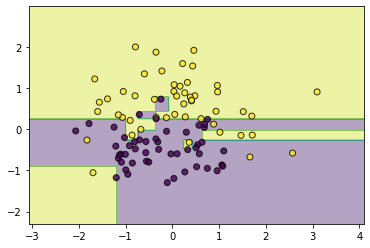

In [55]:
tree = CARTClassifier()
tree.fit(data, target)
utils.plot_decision_function(data, target,tree)

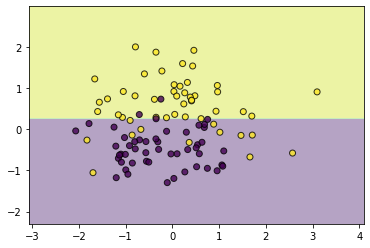

In [56]:
#剪枝后防止过拟合
tree.prune(5)
utils.plot_decision_function(data, target, tree)

In [151]:
#均方误差的一些方法
#计算方差
def sqaure_error(x, sample_weight=None):
    x = np.asarray(x)
    x_mean = np.mean(x)
    # sample weight为不同部分对应的权重，若为none，赋值为全一
    if sample_weight is None:
        sample_weight = np.ones([1.0] * len(x))
    error = 0.0
    # 计算方差
    for i in range(0, len(x)):
        error += (x[i]-x_mean) * (x[i] - x_mean) * sample_weight[i]
    return error

def cond_sqaure_error(x, y, sample_weight=None):
    """
    统计按x的分组的y的误差值
    """
    x = np.asarray(x)
    y = np.asarray(y)
    if sample_weight is None:
        sample_weight = np.asarray([1.0] * x_num)
    error = .0
    for x_value in set(x):
        #按x的值进行分组
        new_x = np.where(x == x_value)
        #获取每个不同的x值的所有y
        new_y = y[new_x]
        new_sample_weight = sample_weight[new_x]
        error += sqaure_error(new_y,new_sample_weight)
    return error

def sqaure_error_gain(x, y, sample_weight=None):
    x_num = len(x)
    if sample_weight is None:
        sample_weight = np.asarray([1.0] * x_num)
    return sqaure_error(y,sample_weight) - cond_sqaure_error(x,y,sample_weight)

In [186]:
#cart回归树的构建

class CARTRegressor(object):
    class Node(object):
        def __init__(self, feature_index:int =None, feature_value=None, y_hat=None, sqaure_error=None, left_child_node=None, right_child_node=None,n_sample:int =None):
            """
            特征id
            特征值
            预测值
            均方误差
            左孩子节点
            右孩子节点
            在此节点的样本数
            """
            self.feature_index = feature_index
            self.feature_value = feature_value
            self.y_hat = y_hat
            self.sqaure_error = sqaure_error
            self.left_child_node = left_child_node
            self.right_child_node = right_child_node
            self.n_sample = n_sample
            
    def __init__(self, critrion = 'mse', max_depth=None, min_sample_split=2, min_sample_leaf=1, min_std=1e-3, min_impurity_decrease=0, max_bins=10):
        """
        最大深度
        对一个内部节点，划分时，该节点上的最小样本数
        最小标准差
        划分一个节点时，当划分过后不纯度减少的值不小于该值，才进行划分
        """
        """
        :param criterion:划分标准，目前仅有平方误差
        :param max_depth:树的最大深度
        :param min_samples_split:当对一个内部结点划分时，要求该结点上的最小样本数，默认为2
        :param min_std:最小的标准差
        :param min_samples_leaf:设置叶子结点上的最小样本数，默认为1
        :param min_impurity_decrease:打算划分一个内部结点时，只有当划分后不纯度(可以用criterion参数指定的度量来描述)减少值不小于该参数指定的值，才会对该结点进行划分，默认值为0
        """
        self.critrion = critrion
        if critrion == 'mse':
            self.critrion_func = utils.square_error_gain
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.min_sample_leaf = min_sample_leaf
        self.min_std = min_std
        self.min_impurity_decrease = min_impurity_decrease
        self.root_node:self.Node = None
        self.dbw = DataBinWrapper(max_bins=max_bins)
        
    #递归构建决策树    
    def build_tree(self, current_depth, current_node:Node, X, y, sample_weight):
        
        rows, cols = X.shape
        #计算y的加权平均值
        current_node.y_hat = np.dot(sample_weight/np.sum(sample_weight), y)
        current_node.n_sample = rows
        #判断停止切分的条件
        current_node.sqaure_error = np.dot(y - np.mean(y), y - np.mean(y))
        if np.sqrt(current_node.sqaure_error / rows) <= self.min_std:
            return
        if rows < self.min_sample_split:
            return 
        if self.max_depth is not None and current_depth > self.max_depth:
            return
        # 切分位置为best_index 切分位置的值为best_value, 切分过后的min{(y-c1)2+(y-c2)2}
        best_index = None
        best_value = None
        best_criterion_value = 0
        for index in range(0, cols):
            for index_value in sorted(set(X[:,index])):
                criterion_value = self.critrion_func((X[:, index] <= index_value).astype(int) , y, sample_weight)
                if criterion_value>best_criterion_value:
                    best_criterion_value = criterion_value
                    best_index = index
                    best_value = index_value
                    
        #切分后的criterion的值若变化不大则返回
        if best_index is None:
            return 
        if best_criterion_value <= self.min_impurity_decrease:
            return
        
        #切分 根据特征x(j)切   left:0-best_index, right best_index:
        current_node.feature_index = best_index
        current_node.feature_value = best_value
        selected_x = X[:, best_index]
        
        #开始构建子树
        #左子树上所有节点
        left_selected_index = np.where(selected_x <= best_value)
        #切分后的点太少以至于都不能做叶子结点则停止分割
        if len(left_selected_index[0]) >= self.min_sample_leaf:
            left_child_node = self.Node()
            current_node.left_child_node = left_child_node
            self.build_tree(current_depth+1, left_child_node,X[left_selected_index], y[left_selected_index],sample_weight[left_selected_index])
        #创建右子树
        right_selected_index = np.where(selected_x > best_value)
        if len(right_selected_index[0]) >= self.min_sample_leaf:
            right_child_node = self.Node()
            current_node.right_child_node = right_child_node
            self.build_tree(current_depth + 1, right_child_node, X[right_selected_index], y[right_selected_index],sample_weight[right_selected_index])
    
    #开始训练
    def fit(self, X, y, sample_weight=None):
        
        n_sample = X.shape[0]
        if sample_weight is None:
            sample_weight = np.asarray([1.0]* n_sample)
        if len(sample_weight) != n_sample:
            raise Exception('sample_weight size error:', len(sample_weight))
        #初始化空的根节点
        self.root_node = self.Node()
        
        #对x进行分箱
        self.dbw.fit(X)
        
        #递归构建树
        self.build_tree(1, self.root_node, self.dbw.transform(X), y, sample_weight)
    
    
    #检索叶子结点的结果
    def search_node(self, current_node: Node, x):
        if current_node.left_child_node is not None and x[current_node.feature_index] <= current_node.feature_value:
            return self.search_node(current_node.left_child_node, x)
        elif current_node.right_child_node is not None and x[current_node.feature_index] > current_node.feature_value:
            return self.search_node(current_node.right_child_node, x)
        else:
            return current_node.y_hat
    
    #计算结果的概率分布
    def predict(self,x):
        x = self.dbw.transform(x)
        rows = x.shape[0]
        result = []
        for row in range(0 , rows):
            result.append(self.search_node(self.root_node,x[row]))
        return np.asarray(result)
        
        

In [187]:
data = np.linspace(1, 10 ,100)

target = np.sin(data) + np.random.random(size= 100)

data = data.reshape((-1,1))

In [188]:
tree_generate = CARTRegressor(max_bins=50)
tree_generate.fit(data, target)

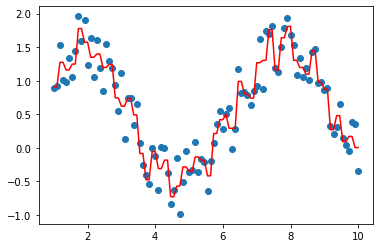

In [189]:
import matplotlib.pyplot as plt
plt.scatter(data, target)
plt.plot(data, tree_generate.predict(data), color ='r')